In [36]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt




In [37]:
# 生成标签值：下一天收盘价（涉及删除最后一条数据，不要重复执行该函数）
def generate_label(data_path):
    df = pd.read_csv(data_path)

    for i in ['xa','ya','za','row','pitch','yaw']:
        next_close = list()
        for j in range(len(df[i])-1):
            next_close.append(df[i][j+1])
        next_close.append(0)
        df['new'+i] = next_close
    df.to_csv('new_UAV.csv',index=None)

# 生成训练和测试数据
def generate_model_data(data_path, alpha, seq_len):
    Mean = dict()
    Std = dict()
    data_path = 'new_UAV.csv'
    df = pd.read_csv(data_path)
    train_seq = int((len(df) - seq_len + 1))
    cnt = 0
    for property in ['xa','ya','za','row','pitch','yaw','newxa','newya','newza','newrow','newpitch','newyaw']:
        df[property] = np.reshape(np.array(df[property]), (-1, 1))
        Mean[cnt] = df[property].mean() 
        Std[cnt] = df[property].std()
        df[property] = (df[property]-Mean[cnt])/Std[cnt]
        cnt = cnt+1

    X_data, Y_data = list(), list()
    # 生成时序数据
    for i in range(train_seq):
        for k in ['newxa','newya','newza','newrow','newpitch','newyaw']:
            Y_data.append(df[k][i + seq_len - 1])
        for j in range(seq_len):
            for m in ['xa','ya','za','row','pitch','yaw']:
                X_data.append(df[m][i + j])
    X_data = np.reshape(np.array(X_data), (-1, 6 * seq_len))  # 表示特征数量*时间步数
    Y_data = np.reshape(np.array(Y_data),(-1,6))
    train_length = int(len(Y_data) * alpha)
    X_train = np.reshape(np.array(X_data[:train_length]), (len(X_data[:train_length]), seq_len, 6))
    X_test = np.reshape(np.array(X_data[train_length:]), (len(X_data[train_length:]), seq_len, 6))
    #Y_train, Y_test = np.array(Y_data[:train_length]), np.array(Y_data[train_length:])
 
    Y_train = np.reshape(np.array(Y_data[:train_length]),(len(Y_data[:train_length]),6))
    Y_test = np.reshape(np.array(Y_data[train_length:]), (len(Y_data[train_length:]),6))
    return X_train, Y_train, X_test, Y_test,train_length,X_data,Y_data,Mean,Std


def calc_MAPE(real, predict):
    Score_MAPE = 0
    for k in range(0,6):
        for i in range(len(predict[:, k])):
            Score_MAPE += abs((predict[:, k][i] - real[:, k][i]) / real[:, k][i])
    Score_MAPE = Score_MAPE * 100 / len(np.reshape(predict,(-1,1)))
    return Score_MAPE


def calc_AMAPE(real, predict):
    Score_AMAPE = 0
    for k in range(0,6):
        Score_MAPE_DIV = sum(real[:, k]) / len(real[:, k])
        for i in range(len(predict[:, k])):
            Score_AMAPE += abs((predict[:, k][i] - real[:, k][i]) / Score_MAPE_DIV)
    Score_AMAPE = Score_AMAPE * 100 / len(np.reshape(predict[:, 0],(-1,1)))
    return Score_AMAPE


def evaluate(real, predict):
    RMSE = math.sqrt(mean_squared_error(real[:, 0], predict[:, 0]))
    MAE = mean_absolute_error(real[:, 0], predict[:, 0])
    MAPE = calc_MAPE(real, predict)
    AMAPE = calc_AMAPE(real, predict)
    return RMSE, MAE, MAPE, AMAPE





if __name__ == '__main__':
    data_path = 'UAV.csv'
    seq_len = 50
    alpha = 0.8
    #generate_label(data_path)
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = StandardScaler()
    X_train, Y_train, X_test, Y_test,train_length,X_data,Y_data,Mean,Std= generate_model_data('new_UAV.csv', alpha, seq_len)
    

In [38]:
def lstm_model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(6, activation='hard_sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=1000, batch_size=100, verbose=1)

    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    ## 恢复原数值
    for i in range(6,12):
        trainPredict[:,i-6] = trainPredict[:,i-6]*Std[i]+Mean[i] 
        Y_train = np.reshape(Y_train, (-1, 6))
        Y_train[:,i-6] = Y_train[:,i-6]*Std[i]+Mean[i] 
        testPredict[:,i-6] = testPredict[:,i-6]*Std[i]+Mean[i] 
        Y_test = np.reshape(Y_test, (-1, 6))
        Y_test[:,i-6] = Y_test[:,i-6]*Std[i]+Mean[i] 

    return Y_train, trainPredict, Y_test, testPredict,history


In [39]:
train_Y, trainPredict, test_Y, testPredict,history = lstm_model(X_train, Y_train, X_test, Y_test)

Epoch 1/1000
154/154 [==============================] - 9s 44ms/step - loss: 0.6588
Epoch 2/1000
154/154 [==============================] - 6s 38ms/step - loss: 0.5832
Epoch 3/1000
154/154 [==============================] - 7s 48ms/step - loss: 0.5634
Epoch 4/1000
154/154 [==============================] - 6s 38ms/step - loss: 0.5520
Epoch 5/1000
154/154 [==============================] - 10s 66ms/step - loss: 0.5462
Epoch 6/1000
154/154 [==============================] - 7s 43ms/step - loss: 0.5428
Epoch 7/1000
154/154 [==============================] - 8s 50ms/step - loss: 0.5408
Epoch 8/1000
154/154 [==============================] - 6s 41ms/step - loss: 0.5393: 0s - loss: 
Epoch 9/1000
154/154 [==============================] - 7s 43ms/step - loss: 0.5382
Epoch 10/1000
154/154 [==============================] - 7s 44ms/step - loss: 0.5373
Epoch 11/1000
154/154 [==============================] - 6s 42ms/step - loss: 0.5367
Epoch 12/1000
154/154 [==============================] - 7s 

Epoch 97/1000
154/154 [==============================] - 7s 45ms/step - loss: 0.5315
Epoch 98/1000
154/154 [==============================] - 7s 43ms/step - loss: 0.5314
Epoch 99/1000
154/154 [==============================] - 7s 47ms/step - loss: 0.5314
Epoch 100/1000
154/154 [==============================] - 7s 43ms/step - loss: 0.5314
Epoch 101/1000
154/154 [==============================] - 7s 48ms/step - loss: 0.5314
Epoch 102/1000
154/154 [==============================] - 7s 43ms/step - loss: 0.5314
Epoch 103/1000
154/154 [==============================] - 7s 46ms/step - loss: 0.5314
Epoch 104/1000
154/154 [==============================] - 7s 44ms/step - loss: 0.5314: 0s - 
Epoch 105/1000
154/154 [==============================] - 7s 43ms/step - loss: 0.5314
Epoch 106/1000
154/154 [==============================] - 7s 47ms/step - loss: 0.5314
Epoch 107/1000
154/154 [==============================] - 7s 42ms/step - loss: 0.5314
Epoch 108/1000
154/154 [==========================

154/154 [==============================] - 9s 57ms/step - loss: 0.5313: 0s - loss: 0.531
Epoch 192/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5313
Epoch 193/1000
154/154 [==============================] - 9s 57ms/step - loss: 0.5313: 0s - l
Epoch 194/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5313
Epoch 195/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5313
Epoch 196/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5313
Epoch 197/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5313
Epoch 198/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5313
Epoch 199/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5313
Epoch 200/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5314
Epoch 201/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5314
Epoch 202/1000
154/154 [===================

154/154 [==============================] - 8s 53ms/step - loss: 0.5313
Epoch 285/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5313
Epoch 286/1000
154/154 [==============================] - 8s 51ms/step - loss: 0.5313
Epoch 287/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5313
Epoch 288/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5313
Epoch 289/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5313
Epoch 290/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5313
Epoch 291/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5313
Epoch 292/1000
154/154 [==============================] - 9s 55ms/step - loss: 0.5313
Epoch 293/1000
154/154 [==============================] - 9s 55ms/step - loss: 0.5313
Epoch 294/1000
154/154 [==============================] - 9s 57ms/step - loss: 0.5313
Epoch 295/1000
154/154 [==============================] - 8s 53ms/ste

154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 378/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5313
Epoch 379/1000
154/154 [==============================] - 9s 57ms/step - loss: 0.5313
Epoch 380/1000
154/154 [==============================] - 8s 55ms/step - loss: 0.5313
Epoch 381/1000
154/154 [==============================] - 8s 55ms/step - loss: 0.5313
Epoch 382/1000
154/154 [==============================] - 10s 63ms/step - loss: 0.5312 0s - loss: 0.52
Epoch 383/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5312
Epoch 384/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312
Epoch 385/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5312
Epoch 386/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5313
Epoch 387/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5313
Epoch 388/1000
154/154 [============================

154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 471/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 472/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5313
Epoch 473/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5313
Epoch 474/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5313
Epoch 475/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312
Epoch 476/1000
154/154 [==============================] - 9s 56ms/step - loss: 0.5312
Epoch 477/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312: 0s - loss
Epoch 478/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 479/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312
Epoch 480/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 481/1000
154/154 [==============================] - 

154/154 [==============================] - 10s 62ms/step - loss: 0.5313
Epoch 564/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 565/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 566/1000
154/154 [==============================] - 9s 57ms/step - loss: 0.5312
Epoch 567/1000
154/154 [==============================] - 9s 57ms/step - loss: 0.5312
Epoch 568/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312: 0s - loss: 0.5
Epoch 569/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 570/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 571/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5312
Epoch 572/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312
Epoch 573/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312: 2s - l
Epoch 574/1000
154/154 [====================

154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 657/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 658/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 659/1000
154/154 [==============================] - 9s 56ms/step - loss: 0.5312
Epoch 660/1000
154/154 [==============================] - 8s 55ms/step - loss: 0.5312
Epoch 661/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312
Epoch 662/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 663/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5312
Epoch 664/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 665/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312
Epoch 666/1000
154/154 [==============================] - 8s 51ms/step - loss: 0.5313
Epoch 667/1000
154/154 [==============================] - 9s 59ms/ste

154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 751/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5312
Epoch 752/1000
154/154 [==============================] - 8s 50ms/step - loss: 0.5312
Epoch 753/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312
Epoch 754/1000
154/154 [==============================] - 8s 50ms/step - loss: 0.5312
Epoch 755/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 756/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 757/1000
154/154 [==============================] - 9s 57ms/step - loss: 0.5312
Epoch 758/1000
154/154 [==============================] - 9s 56ms/step - loss: 0.5312: 0s - loss: 0
Epoch 759/1000
154/154 [==============================] - 9s 55ms/step - loss: 0.5312
Epoch 760/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5312
Epoch 761/1000
154/154 [==============================]

154/154 [==============================] - 9s 58ms/step - loss: 0.5312
Epoch 844/1000
154/154 [==============================] - 9s 56ms/step - loss: 0.5312
Epoch 845/1000
154/154 [==============================] - 9s 56ms/step - loss: 0.5312
Epoch 846/1000
154/154 [==============================] - 9s 58ms/step - loss: 0.5312: 1s - loss:  - ETA
Epoch 847/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5312
Epoch 848/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312: 1s - - E
Epoch 849/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 850/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312: 0s - loss: 0.53
Epoch 851/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5312
Epoch 852/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312
Epoch 853/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 854/1000
154/154 

154/154 [==============================] - 9s 56ms/step - loss: 0.5312
Epoch 937/1000
154/154 [==============================] - 9s 62ms/step - loss: 0.5312
Epoch 938/1000
154/154 [==============================] - 8s 53ms/step - loss: 0.5312
Epoch 939/1000
154/154 [==============================] - 9s 60ms/step - loss: 0.5312
Epoch 940/1000
154/154 [==============================] - 8s 52ms/step - loss: 0.5312
Epoch 941/1000
154/154 [==============================] - 9s 61ms/step - loss: 0.5312
Epoch 942/1000
154/154 [==============================] - 8s 54ms/step - loss: 0.5312
Epoch 943/1000
154/154 [==============================] - 9s 62ms/step - loss: 0.5312
Epoch 944/1000
154/154 [==============================] - 9s 55ms/step - loss: 0.5312
Epoch 945/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312
Epoch 946/1000
154/154 [==============================] - 9s 59ms/step - loss: 0.5312
Epoch 947/1000
154/154 [==============================] - 8s 54ms/ste

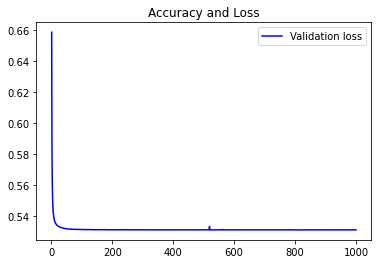

In [40]:


loss = history.history['loss']
epochs = range(1, len(loss) + 1)
 
plt.title('Accuracy and Loss')

plt.plot(epochs, loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

In [78]:
testPredict.shape

(3801, 6)

In [79]:
testPredict[2000]

array([-9.4279333e-12, -1.0288640e-13,  2.0613359e-01,  2.5895984e+00,
       -2.3267719e-04, -1.4744103e-03], dtype=float32)

In [41]:
RMSE, MAE, MAPE, AMAPE = evaluate(test_Y, testPredict)
print(RMSE, MAE, MAPE, AMAPE)


21.674785005288044 2.6152200933478156 inf 3578196.7307087453


E:\Temp/ipykernel_25212/2821199893.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  Score_MAPE += abs((predict[:, k][i] - real[:, k][i]) / real[:, k][i])


In [85]:
np.savetxt('trainPredict.csv', trainPredict, delimiter=',')
np.savetxt('testPredict.csv',testPredict,delimiter=',')

In [21]:
trainPredict[:,1].shape,train_Y.shape

((15203,), (15203, 6))

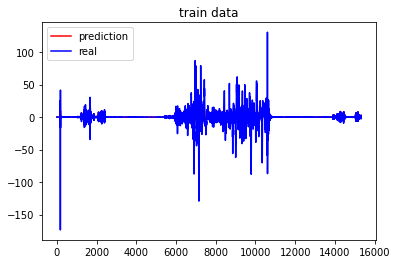

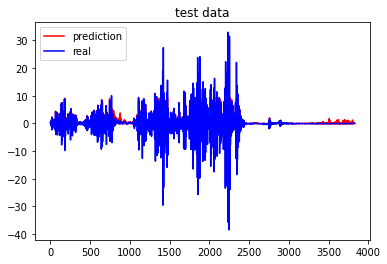

In [42]:
i=3
plt.plot(list(trainPredict[:,i]), color='red', label='prediction')
plt.plot(list(train_Y[:,i]), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('train data')
plt.show()

plt.plot(list(testPredict[:,i]), color='red', label='prediction')
plt.plot(list(test_Y[:,i]), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('test data')
#plt.suptitle('units==20,RMSE=\d,MAE=\d,MAPE=\d,AMAPE=\d',RMSE,MAE,MAPE,AMAPE)
plt.show()
    

In [9]:
len(test_Y)/6
testPredict.shape

(3801, 6)

In [86]:
np.savetxt('train_Y.csv',train_Y,delimiter=',')
np.savetxt('test_Y.csv',test_Y,delimiter=',')

(19004, 1200)